In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy
import pickle
import torch
import torch.nn as nn
import time
import sympy as sy
import imageio
import glob 
import matplotlib.tri as tri

# Add source and data file paths
import os
path = os.path.abspath(os.getcwd())
os.chdir("../..")
parent_path = os.path.abspath(os.getcwd())

import sys 
sys.path.insert(1, parent_path + '\\source')
sys.path.insert(2, parent_path + '\\data')

# Import helper classes/functions
from network_helper import Net, PI_DON_reg
from data_helper import pde_exact
from misc_helper import animation, training_results, knw_log, competitive_plot
from knw_helper import coeff, K_n_width

# Step 1: Load in and visualize data

In [2]:
PDE = 'allencahn'

with open(parent_path + '\\data\\' + 'allenCahn2D_dict.pickle', 'rb') as handle:
    allenCahn2D_dict = pickle.load(handle)

u_ls = np.array(allenCahn2D_dict['u'])
f_ls = np.array(allenCahn2D_dict['f'])
c_ls = np.array(allenCahn2D_dict['c'])
x = allenCahn2D_dict['x']
y = allenCahn2D_dict['y']

# Plot
X, Y = np.meshgrid(x,y)
XY = np.concatenate((X.flatten().reshape(-1,X.flatten().shape[-1]), Y.flatten().reshape(-1,Y.flatten().shape[-1]))).T
triang = tri.Triangulation(X.flatten(), Y.flatten())
xb = np.concatenate((np.concatenate((np.array([X[0,:],Y[0,:]]),np.array([X[-1,:],Y[-1,:]])),-1),np.concatenate((np.array([X[:,0],Y[:,0]]),np.array([X[:,-1],Y[:,-1]])),-1)),-1).T

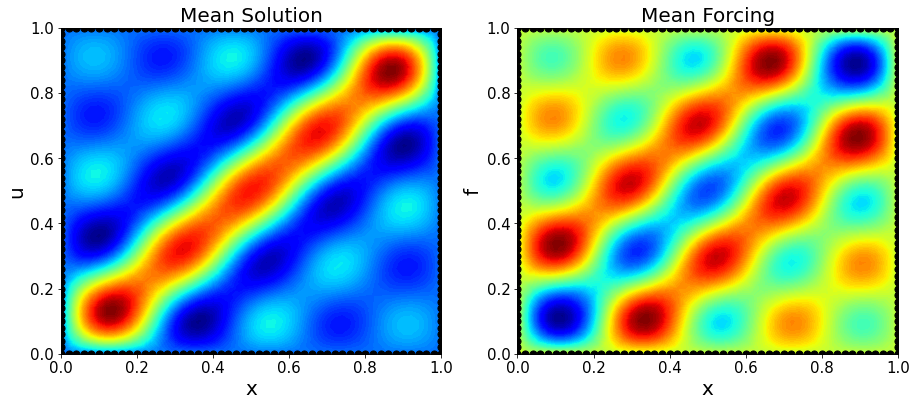

In [3]:
# Plot
plt.figure(figsize = (15,6))

plt.subplot(1,2,1)
plt.tricontourf(triang, np.mean(np.array(u_ls),0).flatten(), 100, cmap = 'jet')
plt.subplot(1,2,2)
plt.tricontourf(triang, np.mean(np.array(f_ls),0).flatten(), 100, cmap = 'jet')
    
plt.subplot(1,2,1)
plt.scatter(xb[:,0],xb[:,1], c ='k', s = 50)
plt.ylabel('u', fontsize=20); plt.xlabel('x', fontsize=20); plt.title('Mean Solution', fontsize=20);
plt.xticks(fontsize=15); plt.yticks(fontsize=15); 
plt.subplot(1,2,2)
plt.scatter(xb[:,0],xb[:,1], c ='k', s = 50)
plt.ylabel('f', fontsize=20); plt.xlabel('x', fontsize=20); plt.title('Mean Forcing', fontsize=20);
plt.xticks(fontsize=15); plt.yticks(fontsize=15);

# Step 2: Initialize and train multitask model

In [4]:
input_y_b = []
input_u = []
physicsInformed_u = []
input_y_f = []
output_b = []

input_y_b = xb
input_y_f = XY

for i in range(len(u_ls)):
    input_u.append(c_ls[i][:]) 
    physicsInformed_u.append(f_ls[i].flatten()) 
    output_b.append([u_ls[i][0], u_ls[i][-1]]) 
    
# PI-DON
number_of_cases = 20
branch_layers = [5,20,20]
trunk_layers = [2,20,20]
model_name = 'don_sine_reg'; act = 'sin'; verbose = 1; epoch = 1000

torch.manual_seed(1); np.random.seed(1)
model_pidon = PI_DON_reg(input_u, physicsInformed_u, input_y_f, input_y_b, output_b, branch_layers, trunk_layers, number_of_cases, act, PDE, X, Y)

G:\My Drive\Research\Notebook files\n-width\K-n-width\Version 2\Version 3\source\network_helper.py:487: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  self.input_u = torch.tensor(input_u, dtype = torch.float32, requires_grad=True)


In [5]:
print('PI-DON')
start_time = time.time()
# Adam training
print('Train Adam:')
model_pidon.train(epoch)
# LBFGS training
print('Train L-BFGS:')
# Optimization Hyperparameters for LBFGS
lr = 0.1; max_iter = 5000; max_eval = None; tolerance_grad = -1; tolerance_change = -1; history_size = 50;
model_pidon.train_lbfgs(lr, max_iter, max_eval, tolerance_grad, tolerance_change, history_size)
elapsed = time.time() - start_time            
print('Training time: %.4f' % (elapsed))

PI-DON
Train Adam:
Epoch:  0
loss:6399.14
Kwn loss: 829.825
Epoch:  100
loss:5816.58
Kwn loss: 281.801
Epoch:  200
loss:5823.32
Kwn loss: 290.11
Epoch:  300
loss:5828.29
Kwn loss: 296.538
Epoch:  400
loss:5829.41
Kwn loss: 299.708
Epoch:  500
loss:5827.7
Kwn loss: 299.528
Epoch:  600
loss:5829.18
Kwn loss: 302.48
Epoch:  700
loss:5835.92
Kwn loss: 310.678
Epoch:  800
loss:5843.01
Kwn loss: 319.616
Epoch:  900
loss:5848.24
Kwn loss: 328.094
Knw: tensor(458.1833, dtype=torch.float64)
Train L-BFGS:
L-BFGS iter:  500
loss:1796.45
Kwn loss: 164.069
L-BFGS iter:  1000
loss:1136.76
Kwn loss: 134.961
L-BFGS iter:  1500
loss:134.693
Kwn loss: 36.6289
L-BFGS iter:  2000
loss:55.9863
Kwn loss: 21.532
L-BFGS iter:  2500
loss:34.4019
Kwn loss: 19.8198
L-BFGS iter:  3000
loss:27.6128
Kwn loss: 19.1986
L-BFGS iter:  3500
loss:24.4107
Kwn loss: 18.6746
L-BFGS iter:  4000
loss:22.6677
Kwn loss: 18.2612
L-BFGS iter:  4500
loss:21.211
Kwn loss: 17.7042
L-BFGS iter:  5000
loss:20.0896
Kwn loss: 17.0698
Tr

# Step 3: Visualize training results

Relative L2 Error (mean): 0.06510060277875404
Relative L2 Error (std): 0.027795866188679966
Relative L2 Error (median): 0.06467833709198648
Relative L2 Error (min-max): [0.020751567393482873, 0.12900451300971508]
2-Norm Error (mean): 1.925140583252751
2-Norm Error (std): 0.7997643769084736


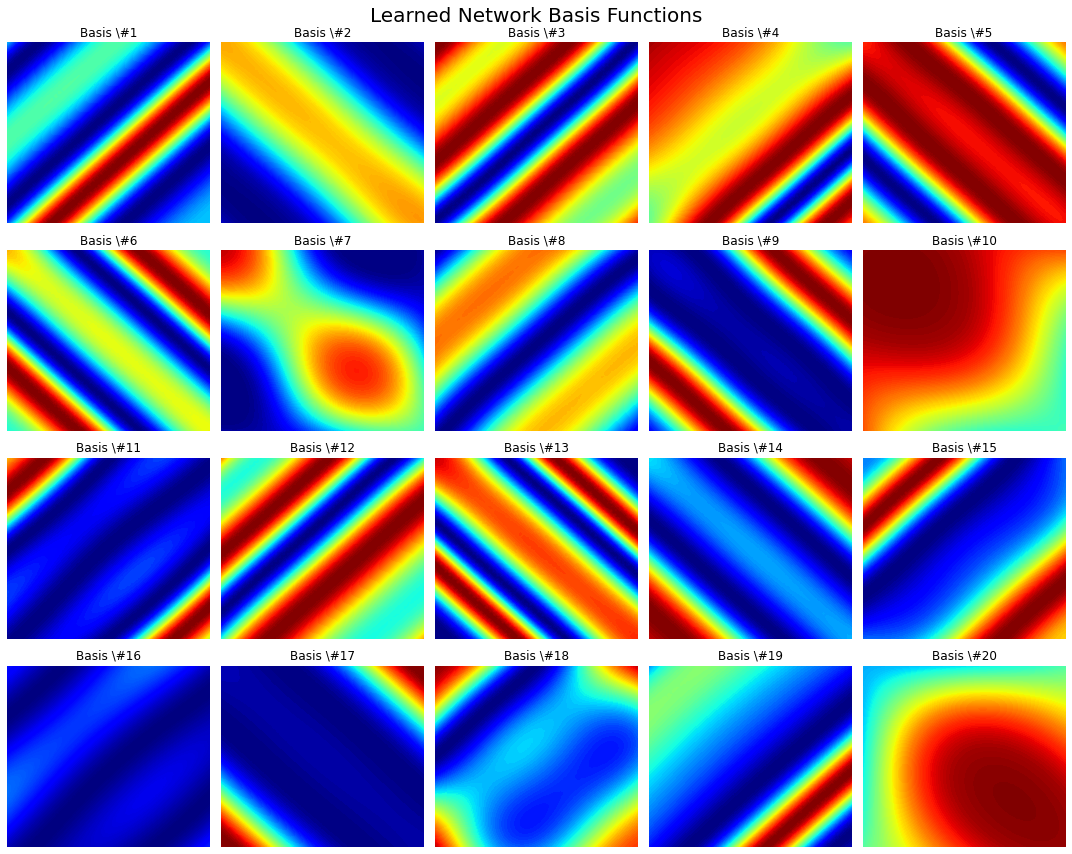

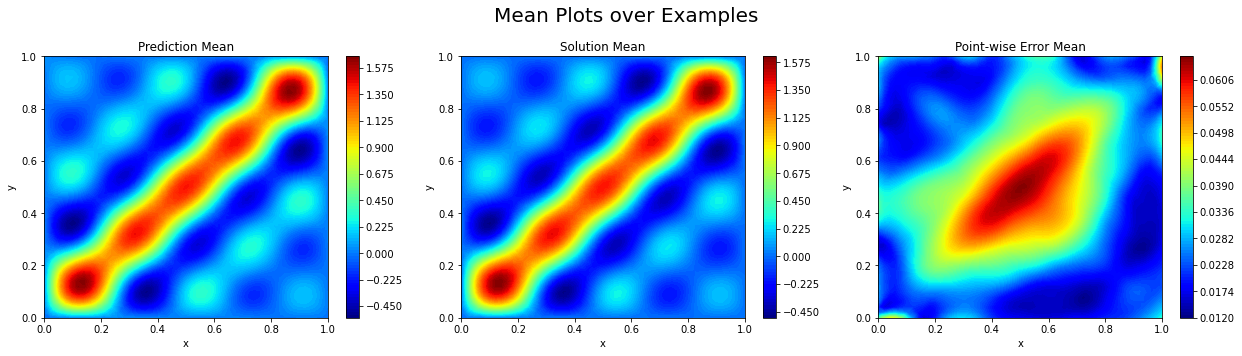

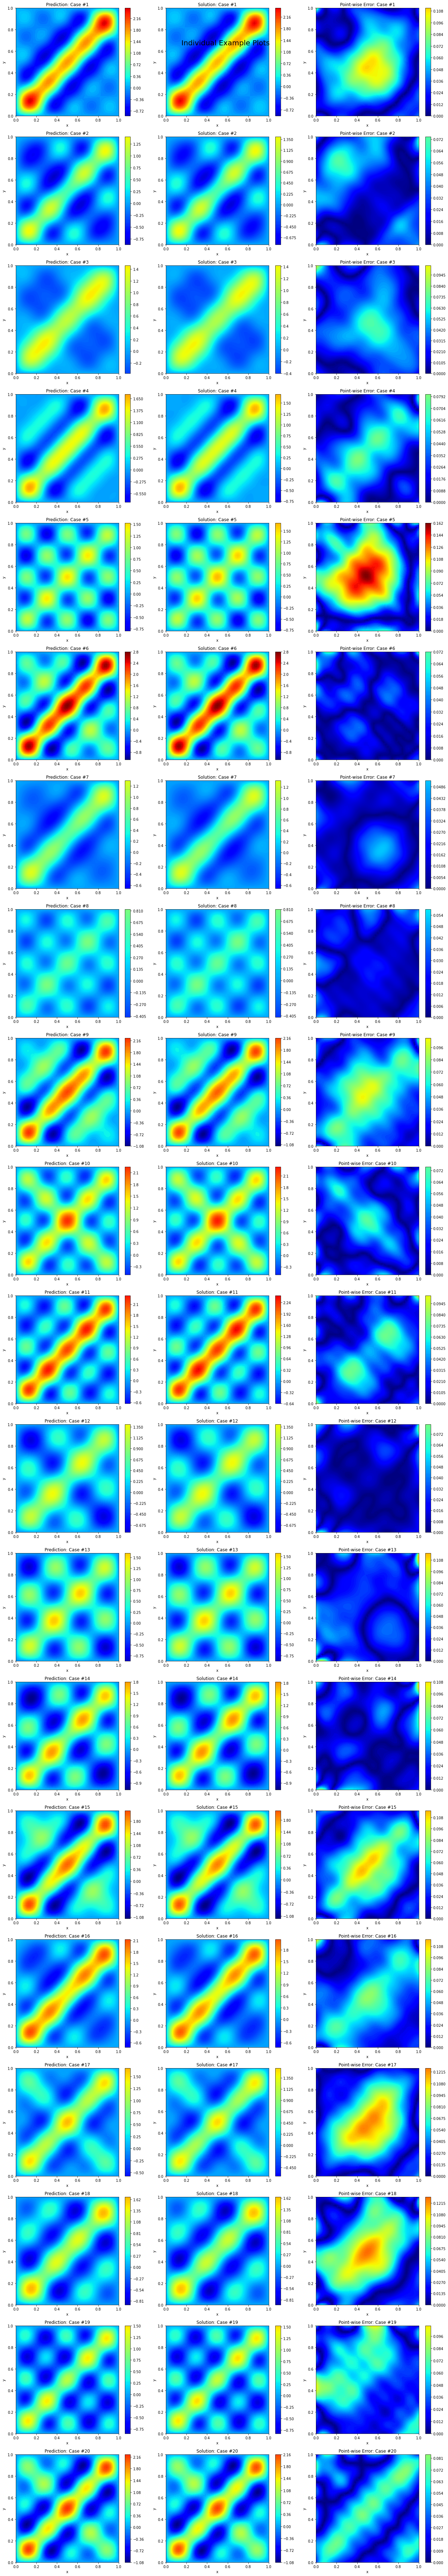

In [6]:
# Predictions
pidon_u_pred, basis, coeff = model_pidon.pred(input_u, XY)
# Call helper function
l2_error_ls = training_results(number_of_cases, x, xb, u_ls, pidon_u_pred, basis, trunk_layers, path, model_name, PDE, triang)

# Step 4: Compute K n-width metric

In [7]:
# Competative optimization
exact = pde_exact() # Needed for error estimate
solution_basis = np.array([(np.sin(X*np.pi)*np.sin(Y*np.pi)).flatten(), (np.sin(2*X*np.pi)*np.sin(2*Y*np.pi)).flatten(), (np.sin(3*X*np.pi)*np.sin(3*Y*np.pi)).flatten(), (np.sin(4*X*np.pi)*np.sin(4*Y*np.pi)).flatten(), (np.sin(5*X*np.pi)*np.sin(5*Y*np.pi)).flatten()])
model_basis = basis.detach().numpy().T

In [8]:
# Create bi-optimization problem
torch.manual_seed(0); np.random.seed(0)
verbose = 0; adam_lr = 0.001; animate = 0;  comp_plot = 1
KnW = K_n_width(solution_basis, model_basis, adam_lr, verbose, exact, 0, None, None)

In [9]:
# Training and animation
epochs = 5000
gif_num = 100; subepoch = int(epochs/gif_num)
log = knw_log()

fig_num = 0
for i in range(gif_num):
    u_c_optimized, u_W1_optimized, u_c_coeff, u_W1_coeff = KnW.solution()
    log.add(x, u_c_optimized, u_W1_optimized)
    if animate == 1:
        animation(path, model_name, fig_num, x, u_c_optimized, u_W1_optimized, PDE, y, triang)
    KnW.train_adam(subepoch)
    fig_num += 1

knw_metric = KnW.metric().detach().numpy()
knw_l2_error = np.linalg.norm(u_c_optimized.detach().numpy()-u_W1_optimized.detach().numpy(), 2)/np.linalg.norm(u_c_optimized.detach().numpy(), 2)
print('KnW Metric:', knw_metric)
print('KnW Rel L2 Error:', knw_l2_error)

KnW Metric: 5.85988226824911
KnW Rel L2 Error: 0.1692429184284265


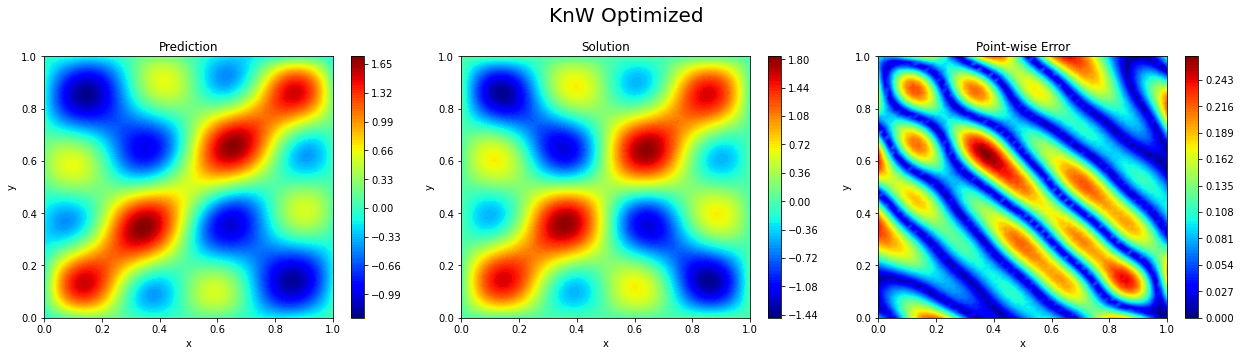

In [10]:
if animate == 1:
    impath = glob.glob(path + '\\figures\\' + model_name + '_animate_' + '*.png')
    images = [];
    for filename in impath:
        images.append(imageio.imread(filename))
    imageio.mimsave(path + '\\figures\\' + model_name + '.mp4', images, macro_block_size = 1)

if comp_plot == 1:
    competitive_plot(path, model_name, log.report(), len(log.report())-1, PDE, x, y, triang)

In [11]:
# Save data
log_dict = {'l2_error_ls': l2_error_ls, 'knw_l2_error': knw_l2_error, 'model_basis': model_basis, 'knw_log': log.report()}

with open(path + '\\log\\' + model_name + '_log_dict.pickle', 'wb') as handle:
    pickle.dump(log_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)